# Installazione

Installiamo le librerie necessarie.

In [1]:
!pip install langchain langchain-openai openai > /dev/null

# Definire un LLM

### Preparare le variabili d'ambiente con i codici di attivazione

In questo caso usiamo una istanza di **OpenAI** su piattaforma **MS Azure**.

_NOTA_: le credenziali resteranno attive per i 2 gg successivi al termine del corso.

In [2]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("API KEY: ")
os.environ["OPENAI_API_VERSION"] = "2024-02-01"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://mg-openai-adv.openai.azure.com/"

API KEY: ········


### Instanziare l'oggetto di gestione dell'LLM

La classe da usare dipende dal tipo di LLM da utilizzare

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(deployment_name="mg-gpt-4-0613", temperature=0.9)

### Splitting del testo

I LLM hanno dei limiti sul testo che possono gestire sia in ingresso che in uscita.

Per testi molto lunghi è necessario una elaborazione "a pezzi".

Il testo viene suddiviso in `chunk`, utilizzando diverse tecniche che tentano di mantenere una certa omogeneità nel contesto.

Spesso questi chunk hanno una leggera sovrapposizione (la parte iniziale chunk N+1 corrisponde alla parte finale del chunk N).

Anche questo serve a dare una certa continuità al contesto tra chunk adiacenti.

In [4]:
with open("IlPiccoloPrincipe-Wikipedia.txt", "r") as f:
    testo = f.read()

print(f"Il testo completo è lungo {len(testo)} caratteri")

Il testo completo è lungo 6926 caratteri


In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Creazione di un'istanza di RecursiveCharacterTextSplitter che divide per TOKEN
# Il TOKEN è l'unità linguistica gestita dagli LLM.
# Mediamente 1 TOKEN = 0.75 parole (dipende dalla lunghezza delle parole)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1024, # Dimensione del chunk
    chunk_overlap=256 # Sovrapposizione tra i chunk
)
chunks = text_splitter.split_text(testo)

print(f"Il testo è stato suddiviso in {len(chunks)} pezzi.")
for c_id, c in enumerate(chunks, 1):
    print(f"Il pezzo {c_id} è lungo {len(c)} caratteri")

Il testo è stato suddiviso in 3 pezzi.
Il pezzo 1 è lungo 2635 caratteri
Il pezzo 2 è lungo 2432 caratteri
Il pezzo 3 è lungo 2061 caratteri


### Processing `map-reduce`

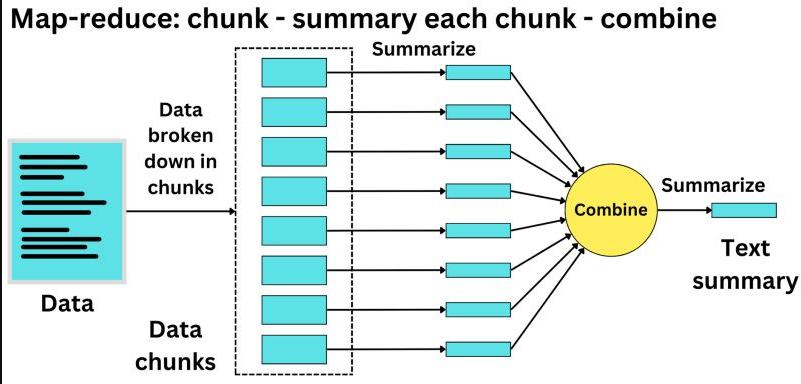

Il processing `map-reduce` consiste in due fasi.

- Nella prima fase (`map`) ogni chunk viene elaborato da un prompt. Questa elaborazione viene eseguita in parallelo.
- Nella seconda fase (`reduce`) i risultati di ogni `map` precedente vengono combinati tra loro attraverso l'uso di un ulteriore prompt.

Questo processo è spesso utilizzato per riassumere testi lunghi, ma il suo concetto può essere riusato anche in altri task.

In [6]:
from langchain.chains import load_summarize_chain
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document


# Definizione del prompt per il passaggio "map"
map_template = """Di seguito è fornito un elenco di documenti:

{text}

Sulla base di questo elenco di documenti, identifica i temi principali.
"""
map_prompt = PromptTemplate.from_template(map_template)

# Definizione del prompt per il passaggio "reduce"
reduce_template = """Di seguito è fornito un elenco di riassunti:

{text}

Analizzali e distillali in un unico, conciso e coerente riassunto.
"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

# Definizione della catena "map-reduce"
chain = load_summarize_chain(
    llm=llm,
    chain_type="map_reduce",
    map_prompt=map_prompt,
    combine_prompt=reduce_prompt,
    input_key="input_documents",
    output_key="output_text"
)

print(chain.invoke({"input_documents": [Document(page_content=c) for c in chunks]})[chain.output_key])

"Il Piccolo Principe", opera di Antoine de Saint-Exupéry, è un testo allegorico che critica la società adulta attraverso gli occhi di un piccolo principe proveniente da un asteroide. Racconta la storia del suo incontro con un pilota di aerei, delle avventure intraprese e dei personaggi che incontra, ognuno dei quali rappresenta diverse lezioni di vita. Questo viaggio porta il piccolo principe a riflettere su temi come l'amore, l'amicizia, la vanità e la solitudine. Il libro, dedicato a Léon Werth, è adornato da illustrazioni dell'autore stesso ed è uno dei più venduti e noti del XX secolo.


### Processing `refine`

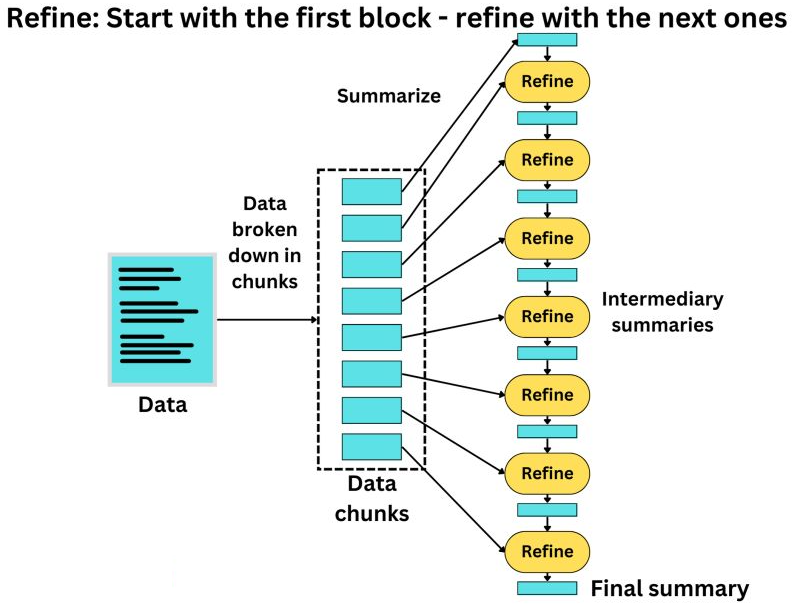

Il processing `refine` consiste in una sequenza di fasi non parallelizzabili.

Il primo passo esegue un prompt sul primo chunk di testo.

Il risultato del primo chunk viene poi **raffinato** con ulteriori informazioni estratte dal secondo chunk.

Il secondo risultato viene ulteriormente raffinato con il terzo chunk e così via fino alla fine.

Anche questo processo è spesso utilizzato per riassumere testi lunghi, ottenendo in generale un riassunto più dettagliato anche se il processo risulta essere molto più lungo visto che non è parallelizzabile per definizione.

In [7]:
# Definizione del primo prompt (eseguito sul primo chunk)
prompt_template = """Scrivi un riassunto conciso del seguente testo:

{text}
"""
prompt = PromptTemplate.from_template(prompt_template)

# Definizione del prompt di raffinamento 
refine_template = """
Il tuo scopo è quello di produrre un riassunto finale.
Di seguito viene fornito un riassunto parziale:

### Riassunto parziale

```
{existing_answer}
```

Ora hai l'opportunità di raffinare il riassunto parziale esistente (solo se necessario) con le informazioni ulteriori che puoi estrarre dal contesto fornito di seguito:

### Contesto ulteriore

```
{text}
```

Dato il nuovo contesto, raffina il riassunto parziale fornito.
Se il nuovo contesto non è utile, restituisci il riassunto parziale fornito.
"""

refine_prompt = PromptTemplate.from_template(refine_template)

# Definizione della catena "refine"
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text"
)

print(chain.invoke({"input_documents": [Document(page_content=c) for c in chunks]})[chain.output_key])

### Riassunto finale

"Il piccolo principe", un celebre best-seller scritto da Antoine de Saint-Exupéry, è un racconto metaforico che esplora temi profondi come il senso della vita, l'amore e l'amicizia. Il libro racconta la storia di un pilota che, nel deserto del Sahara, incontra un bambino di nome Il piccolo principe proveniente dall'asteroide B-612. Il piccolo principe descrive i suoi viaggi attraverso l'universo e le persone bizzarre che ha incontrato, tra cui un re, un vanitoso, un ubriacone, un uomo d'affari, un lampionaio e un geografo. Ciascuno di questi personaggi può essere interpretato come un'allegoria della società contemporanea. Visitando la Terra, il piccolo principe è sorpreso dalla sua ampiezza e popolazione e sperimenta diverse emozioni a seguito di incontri con un serpente, un fiore, un prato di rose e una volpe che gli insegna il significato dell'amicizia. La sua avventura terrestre si conclude quando il serpente, che aveva promesso di riportarlo a casa, lo morde. 